# Using Apache Spark
The following Jupyter notebook will:
- Create a pyspark session
- Define a schema for the data I am uploading
- Open a csv file that is on Google Drive
  - The CSV file is about the Chicago Crimes from 2001 until now - which can be found [here](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data)
- Clean the data:
  - Remove all null values.
  - Change 'Date' column data type
- Filter the data for last ten years.
- Remove all the records with the following crime types:
  - 'NON-CRIMINAL (SUBJECT SPECIFIED)'
  - 'OTHER OFFENSE'
  - 'STALKING'
  - 'NON - CRIMINAL'
  - 'ARSON'
- Merge the similar crime types.
  - For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’ such that they should have the same 'Primary Type'.
- Analyze the data and present results:
  - Show year-wise trend of the crime for last ten years.
  - Find out at which hour of the day crime is highest.
  - Find top ten crimes and present them as a bar chart.

## Importing Libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=b53f72b23c173592ba3f798b14d2f207caaecfa87513e542adb18459f74c47eb
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# Google Drive Libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Python Spark Libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import col, sum, to_timestamp, current_date, date_sub, when, year, count, hour, desc

# Visual Analysis Library
import matplotlib.pyplot as plt

## Importing Data from Google Drive to the Kernel - Chicago Crimes since 2001 to present

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '{FILE_ID}'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Crimes_-_2001_to_Present.csv')

## Create a Spark Session

In [4]:
spark = SparkSession.builder.master("local[1]").appName("Assignment3: Chicago Crime Data - SCA").getOrCreate()

## Define Data Schema

The defined schema can be also find [here](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2).

The dataset have a total of 22 columns

In [5]:
schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Case_Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary_Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location_Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", StringType(), True),
    StructField("Community_Area", StringType(), True),
    StructField("FBI_Code", StringType(), True),
    StructField("X_Coordinate", DoubleType(), True),
    StructField("Y_Coordinate", DoubleType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated_On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])

## Load data

In [6]:
crimes_df = spark.read.csv("Crimes_-_2001_to_Present.csv", schema=schema, header=True)

### Printing Schema

In [7]:
crimes_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case_Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community_Area: string (nullable = true)
 |-- FBI_Code: string (nullable = true)
 |-- X_Coordinate: double (nullable = true)
 |-- Y_Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated_On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [8]:
crimes_df.show(5)

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case_Number|                Date|               Block|IUCR|        Primary_Type|         Description|Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|X_Coordinate|Y_Coordinate|Year|          Updated_On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| 5741943|   HN549294|08/25/2007 09:22:...|  074XX N ROGERS AVE|0560|             ASSAULT|              SIMPLE|             

### Checking number of rows

The dataset should be at least 1 million rows

In [9]:
crimes_df.count()

7917278

## Clean the Data

### Remove Null Values

In [10]:
crimes_df = crimes_df.dropna()

#### Checking Nulls per Columns

In [11]:
crimes_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in crimes_df.columns]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case_Number|Date|Block|IUCR|Primary_Type|Description|Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|X_Coordinate|Y_Coordinate|Year|Updated_On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          0|   0|    0|   0|           0|          0|                   0|     0|       0|   0|       0|   0|             0|       0|           0|           0|   0|         0|       0|        0|       0|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

### Change 'Date' Column Data Type

In [12]:
crimes_df = crimes_df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
crimes_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case_Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community_Area: string (nullable = true)
 |-- FBI_Code: string (nullable = true)
 |-- X_Coordinate: double (nullable = true)
 |-- Y_Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated_On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



## Filtering the data for last 10 years

In [13]:
crimes_df_10= crimes_df.filter(crimes_df.Date >= date_sub(current_date(), 365*10)).orderBy(crimes_df.Date)
crimes_df_10.show(5)

+-------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|     ID|Case_Number|               Date|               Block|IUCR|        Primary_Type|         Description|Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|X_Coordinate|Y_Coordinate|Year|          Updated_On|    Latitude|    Longitude|            Location|
+-------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|9368436|   HW511651|2013-10-25 00:00:00|  080XX S WHIPPLE ST|1750|OFFENSE INVOLVING...|         CHILD ABUSE|           RESIDENCE|

In [14]:
crimes_df_10.select(
    year("Date").alias('year')
).distinct().orderBy(crimes_df_10.Date).show()

+----+
|year|
+----+
|2013|
|2014|
|2015|
|2016|
|2017|
|2018|
|2019|
|2020|
|2021|
|2022|
|2023|
+----+



In [15]:
crimes_df_10.count()

2477460

## Remove all the records with crime types
-  'NON-CRIMINAL (SUBJECT SPECIFIED)'
- 'OTHER OFFENSE'
- 'STALKING'
- 'NON - CRIMINAL'
- 'ARSON'

In [16]:
crimes_df_10_new = crimes_df_10.filter(~col("Primary_Type").isin("NON-CRIMINAL (SUBJECT SPECIFIED)", "OTHER OFFENSE", "STALKING", "NON - CRIMINAL", "ARSON"))
crimes_df_10_new.show(5)

+-------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|     ID|Case_Number|               Date|               Block|IUCR|        Primary_Type|         Description|Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|X_Coordinate|Y_Coordinate|Year|          Updated_On|    Latitude|    Longitude|            Location|
+-------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|9368436|   HW511651|2013-10-25 00:00:00|  080XX S WHIPPLE ST|1750|OFFENSE INVOLVING...|         CHILD ABUSE|           RESIDENCE|

### Checking if the crime types exist

In [17]:
crimes_df_10_new.filter(col("Primary_Type").isin("NON-CRIMINAL (SUBJECT SPECIFIED)", "OTHER OFFENSE", "STALKING", "NON - CRIMINAL", "ARSON")).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case_Number|Date|Block|IUCR|Primary_Type|Description|Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|X_Coordinate|Y_Coordinate|Year|Updated_On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+



## Merging similar crime types

In [24]:
#Lets check top 20 Primary Type
crimes_df_10_new.select("Primary_Type").distinct().show(50)

+--------------------+
|        Primary_Type|
+--------------------+
|OFFENSE INVOLVING...|
|CRIMINAL SEXUAL A...|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|LIQUOR LAW VIOLATION|
| MOTOR VEHICLE THEFT|
|               THEFT|
|             BATTERY|
|             ROBBERY|
|            HOMICIDE|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
|        PROSTITUTION|
|  DECEPTIVE PRACTICE|
|CONCEALED CARRY L...|
|         SEX OFFENSE|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
|          KIDNAPPING|
|            BURGLARY|
|   WEAPONS VIOLATION|
|INTERFERENCE WITH...|
|    PUBLIC INDECENCY|
| CRIM SEXUAL ASSAULT|
|        NON-CRIMINAL|
|OTHER NARCOTIC VI...|
|           RITUALISM|
+--------------------+



In [25]:
similar_crimes_df = crimes_df_10_new.withColumn("Primary_Type",
    when(col("Primary_Type").like("%SEXUAL%"), "SEXUAL ASSAULT")
    .when(col("Primary_Type").like("%THEFT%"), "THEFT")
    .when(col("Primary_Type").like("SEX OFFENSE"), "PROSTITUTION")
    .when(col("Primary_Type").like("%LAW%"), "LAW VIOLATION")
    .when(col("Primary_Type").like("%ROBBERY%"), "THEFT")
    .when(col("Primary_Type").like("%HOMICIDE%"), "HOMICIDE")
    .when(col("Primary_Type").like("%CARRY%"), "GUN INVOLVEMENT")
    .when(col("Primary_Type").like("%WEAPON%"), "GUN INVOLVEMENT")
    .when(col("Primary_Type").like("%NARCOTIC%"), "NARCOTICS")
    .when(col("Primary_Type").like("%TRAFFICKING%"), "HUMAN OR NARCOTICS TRAFFIC")
    .when(col("Primary_Type").like("%OBSCENITY%"), "OBSCENITY")
    .when(col("Primary_Type").like("%INDECENCY%"), "OBSCENITY")
    .when(col("Primary_Type") == "BURGLARY", "THEFT")
    .otherwise(col("Primary_Type"))
)

similar_crimes_df.select("Primary_Type").distinct().show(25)

+--------------------+
|        Primary_Type|
+--------------------+
|OFFENSE INVOLVING...|
|PUBLIC PEACE VIOL...|
|HUMAN OR NARCOTIC...|
|           OBSCENITY|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|               THEFT|
|             BATTERY|
|            HOMICIDE|
|        INTIMIDATION|
|       LAW VIOLATION|
|        PROSTITUTION|
|  DECEPTIVE PRACTICE|
|      SEXUAL ASSAULT|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
|     GUN INVOLVEMENT|
|          KIDNAPPING|
|INTERFERENCE WITH...|
|        NON-CRIMINAL|
|           RITUALISM|
+--------------------+



Some of the most common where merged taking into account that one of the words is in the Primary Type, then it will re-categorize to a general Primary Type.

## Data Analysis

### Year trend of the crime for last ten years

-  Make a count of the number of crimes per year for the last 10 years
- Show a trend using Matplotlib

In [26]:
# group by year and count the number of crimes
crimes_year = similar_crimes_df.groupBy(year("Date").alias("Year")).agg(count("*").alias("Count")).orderBy("Year")

# show the result
crimes_year.show()

+----+------+
|Year| Count|
+----+------+
|2013| 47996|
|2014|256123|
|2015|239889|
|2016|248589|
|2017|246560|
|2018|245378|
|2019|240849|
|2020|193864|
|2021|187552|
|2022|217408|
|2023|189052|
+----+------+



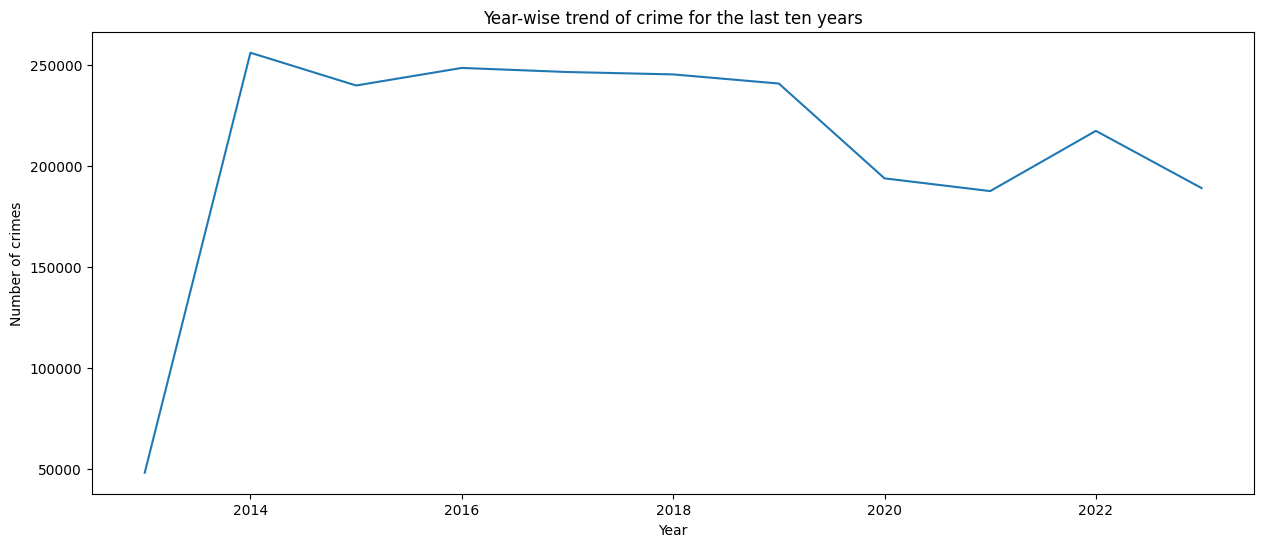

In [31]:
years = [row["Year"] for row in crimes_year.collect()]
counts = [row["Count"] for row in crimes_year.collect()]

plt.figure(figsize=(15,6))
plt.plot(years, counts)

plt.title("Year-wise trend of crime for the last ten years")
plt.xlabel("Year")
plt.ylabel("Number of crimes")


plt.show()

### Hour of the day crime is highest.

- Do the same like last one but group the number of crimes per Hour
- Select max hour

In [35]:
crimes_hour = similar_crimes_df.groupBy(hour("Date").alias("Hour")).agg(count("*").alias("Count")).orderBy(col("Count").desc())

crimes_hour.show(25)

+----+------+
|Hour| Count|
+----+------+
|  12|133768|
+----+------+
only showing top 1 row



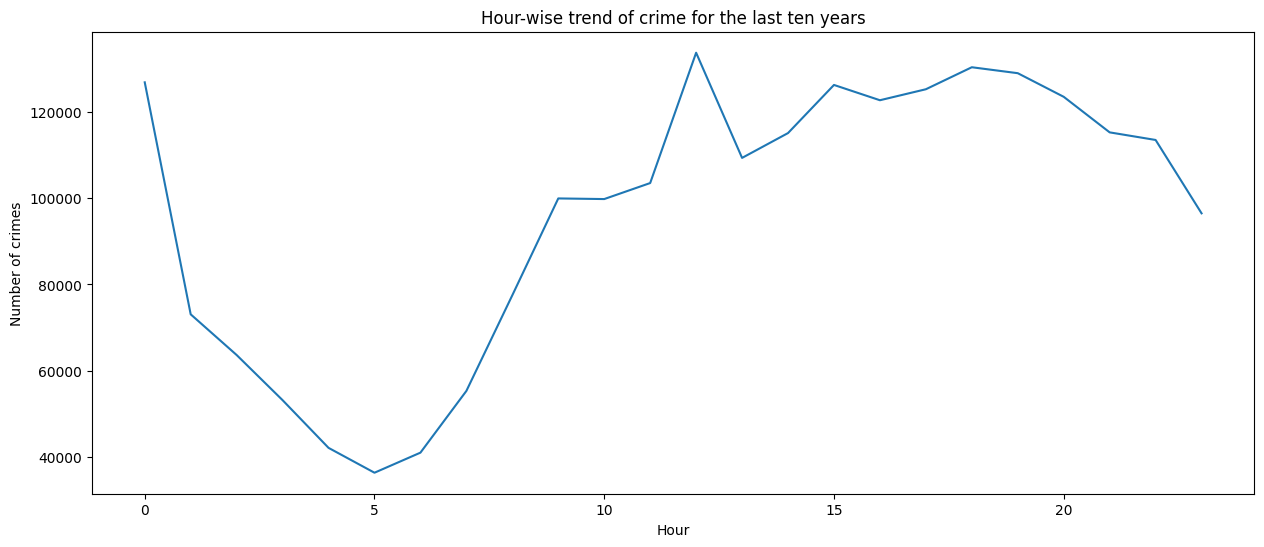

In [37]:
crimes_hour = similar_crimes_df.groupBy(hour("Date").alias("Hour")).agg(count("*").alias("Count")).orderBy("Hour")


hours = [row["Hour"] for row in crimes_hour.collect()]
counts = [row["Count"] for row in crimes_hour.collect()]

plt.figure(figsize=(15,6))
plt.plot(hours, counts)

plt.title("Hour-wise trend of crime for the last ten years")
plt.xlabel("Hour")
plt.ylabel("Number of crimes")


plt.show()

### Top ten crimes

- Count number of crimes per Primary Type
- Select top 10

In [38]:
number_crimes = similar_crimes_df.groupBy("Primary_Type").count()

top_10_crimes = number_crimes.orderBy(desc("count")).limit(10)

top_10_crimes.show()

+--------------------+------+
|        Primary_Type| count|
+--------------------+------+
|               THEFT|889238|
|             BATTERY|462293|
|     CRIMINAL DAMAGE|275496|
|             ASSAULT|192358|
|  DECEPTIVE PRACTICE|156818|
|           NARCOTICS|127806|
|     GUN INVOLVEMENT| 61055|
|   CRIMINAL TRESPASS| 57368|
|OFFENSE INVOLVING...| 20604|
|        PROSTITUTION| 17261|
+--------------------+------+



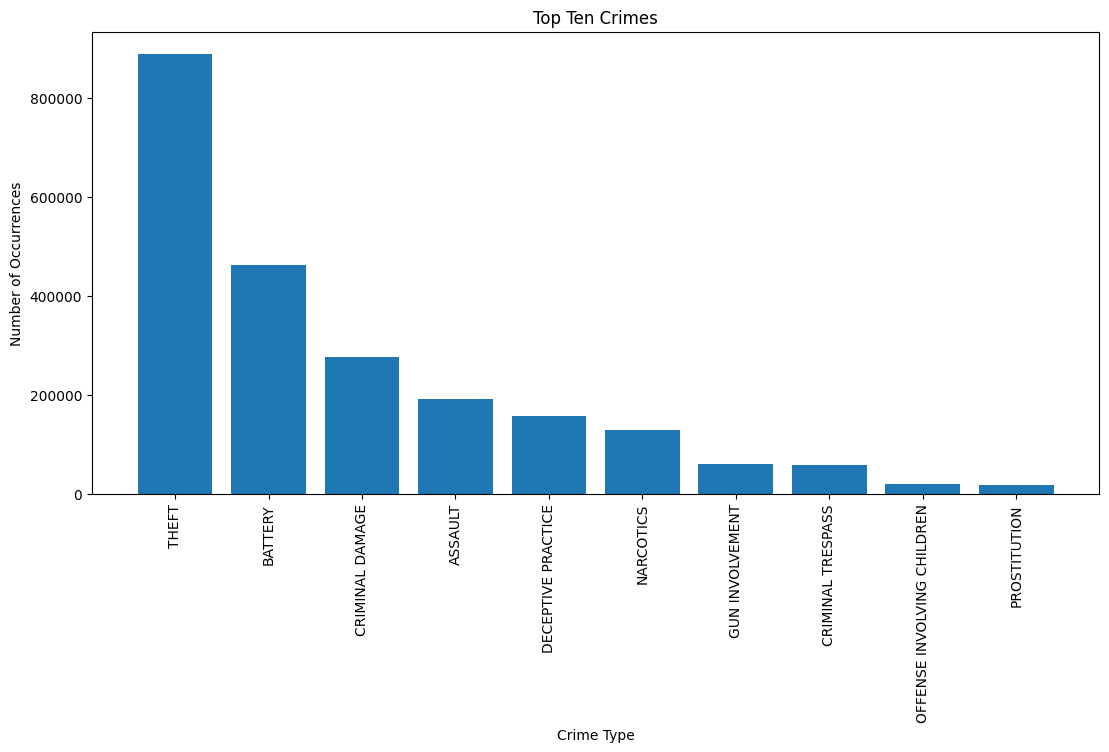

In [40]:
crime_top = top_10_crimes.rdd.map(lambda row: (row[0], row[1])).collect()



plt.figure(figsize=(13,6))
plt.bar(range(len(crime_top)), [x[1] for x in crime_top], align='center')
plt.xticks(range(len(crime_top)), [x[0] for x in crime_top], rotation='vertical')
plt.xlabel('Crime Type')
plt.ylabel('Number of Occurrences')
plt.title('Top Ten Crimes')
plt.show()